In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hybad_dataset.csv")

In [4]:
df.shape

(48107, 5)

In [5]:
df.isnull().sum()

,0
City,0
Datetime,0
NO,1413
NO2,1418
NOx,456


In [6]:
df.describe()

,NO,NO2,NOx
count,46694.000000,46689.000000,47651.000000
mean,7.777900,28.255805,19.429164
std,14.708968,19.837049,17.429067
min,0.030000,0.150000,0.000000
25%,2.410000,13.660000,9.630000
50%,4.000000,23.730000,15.280000
75%,7.400000,37.360000,23.630000
max,304.890000,244.650000,403.820000


<Axes: >

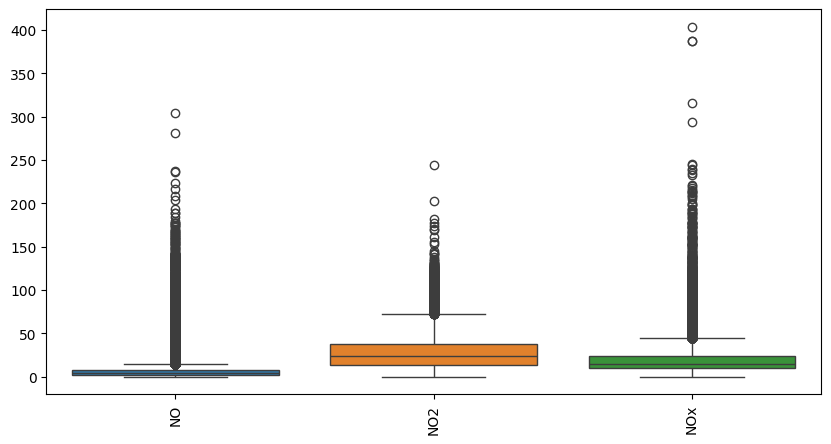

In [7]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.boxplot(data=df, width=0.8)

In [8]:
count = 0
val = ""
l = []

# Create a list of DataFrames, one for each city
for key in df["City"].values:
    if val != key:
        l.append(key)
        count += 1
    val = key

# Process each city's DataFrame individually
for i in range(len(l)):
    l[i] = df[df["City"] == l[i]].copy()  # Use .copy() to avoid chained assignment issues

# Function to fill NaN values based on the mean of the last 4 and next 4 hours
def fill_nan_with_mean(df, key):
    for index in range(len(df)):
        if pd.isna(df.iloc[index][key]):
            start = max(0, index - 4)
            end = min(len(df), index + 5)  # end is exclusive, so +5 gives the next 4 hours
            values = df.iloc[start:end][key]
            values = values.dropna()  # Remove any NaN values within the range
            if not values.empty:
                mean_value = values.mean()
                df.loc[df.index[index], key] = mean_value  # Use df.loc to avoid SettingWithCopyWarning
    return df

# Remove outliers and fill NaN values for each city
for i in l:
    for key in i.columns:
        if key == "AQI_Bucket" or key == "City" or key == "Datetime":
            continue
        # Remove outliers using IQR method
        percentile25 = df[key].quantile(0.25)
        percentile75 = df[key].quantile(0.75)
        interQ = percentile75 - percentile25
        upperlimit = percentile75 + 1.5 * interQ
        lowerLimit = percentile25 - 1.5 * interQ
        i.loc[:, key] = np.where(i[key] > upperlimit, upperlimit,
                                 np.where(i[key] < lowerLimit, lowerLimit, i[key]))
        # Fill NaN values using the mean of last 4 and next 4 hours
        i = fill_nan_with_mean(i, key)

# After processing, you can concatenate all the city DataFrames back into one DataFrame
cleaned_data = pd.concat(l, ignore_index=True)

<Axes: >

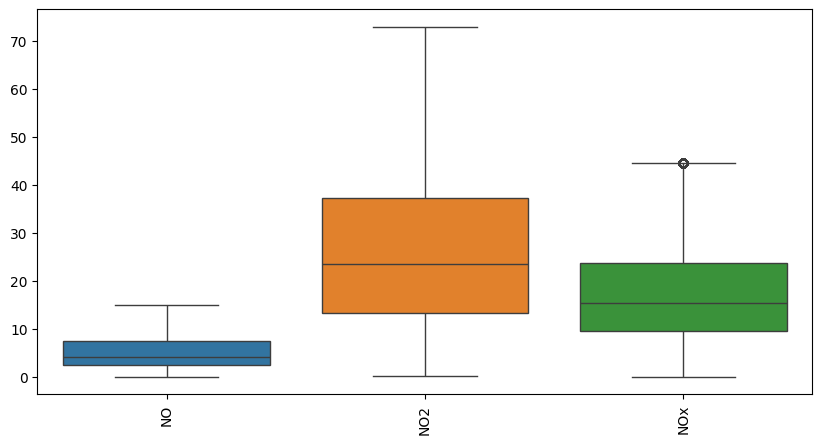

In [9]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.boxplot(data=cleaned_data, width=0.8)

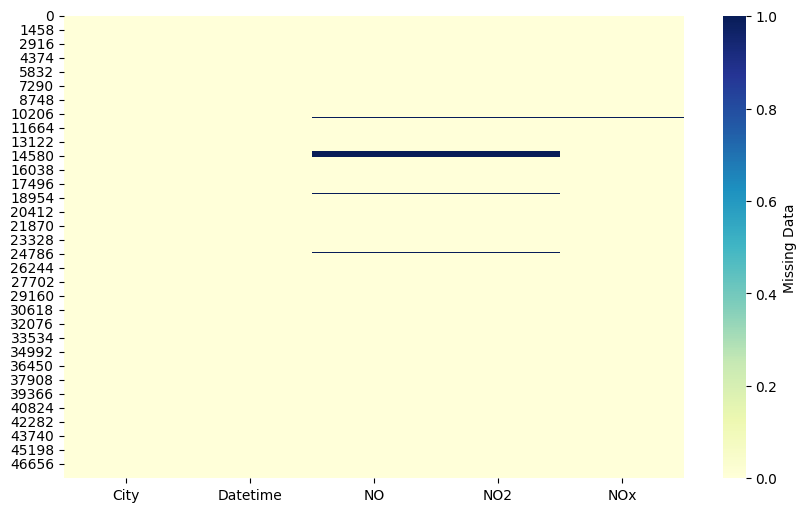

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap='YlGnBu', cbar_kws={'label': 'Missing Data'})
plt.show()

In [11]:
count = 0
val = ""
lio = []

# Create a list of DataFrames, one for each city
for key in cleaned_data["City"].values:
    if val != key:
        lio.append(key)
        count += 1
    val = key

for i in range(len(l)):
    lio[i] = cleaned_data[  cleaned_data["City"] == lio[i]   ]


In [12]:
for i in lio:
    for key in i.columns:
        if key in ["AQI_Bucket", "City", "Datetime"]:
            continue
        meanVal = i[key].mean()
        i.loc[:, key] = i[key].fillna(meanVal)

In [13]:
df1 = pd.DataFrame()
for i in range(len(lio)):
    df1 = pd.concat([df1,lio[i]])

In [14]:
df1.fillna(0, inplace=True)

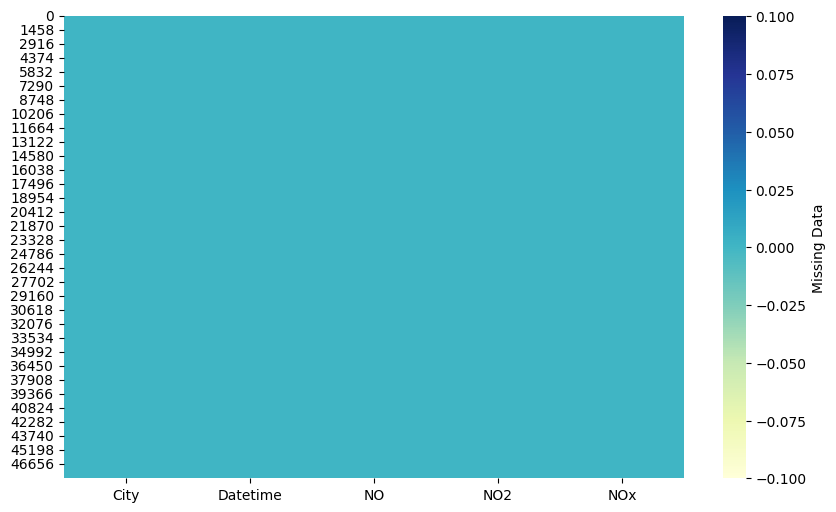

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df1.isna(), cmap='YlGnBu', cbar_kws={'label': 'Missing Data'})
plt.show()

In [18]:
df1.isna().sum()

,0
City,0
Datetime,0
NO,0
NO2,0
NOx,0


In [19]:
df1.describe()

,NO,NO2,NOx
count,48107.00000,48107.000000,48107.000000
mean,5.52529,27.591412,17.933546
std,4.11772,18.234162,11.489852
min,0.03000,0.150000,0.000000
25%,2.45500,13.355000,9.640000
50%,4.10000,23.560000,15.290000
75%,7.43000,37.335000,23.610000
max,14.88500,72.910000,44.630000


In [20]:
df1.to_csv("Hyderabad.csv",index=False)